In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyopenms import *

### Data Loading Functions

In [2]:
def experiment_iter(method, sample = None, penalty = None):
    if sample is None:
        sample = ["UWPROFL0360", "UWPROFL0361", "UWPROFL0362", "UWPROFL0363", "UWPROFL0364"]
    if penalty is None:
        penalty = ["1e5", "3e5", "1e6", "3e6", 
                   "1e7", "3e7", "1e8", "3e8", 
                   "1e9", "3e9", "1e10", "3e10",
                   "1e11", "3e11", "1e12", "3e12", 
                   "1e13", "3e13"]
        
    for s in sample:
        for p in penalty:
            yield s + "_" + method + "_" + p
        
def sgl_iter(l1_penalty, sample = None, l2_penalty = None):
    if sample is None:
        sample = ["UWPROFL0360", "UWPROFL0361", "UWPROFL0362", "UWPROFL0363", "UWPROFL0364"]
    if l2_penalty is None:
        l2_penalty = ["1e8", "3e8", "1e9", "3e9", "1e10", "3e10", "1e11", "3e11"]
        
    for s in sample:
        for p in l2_penalty:
            yield s + "_" + "sglasso" + "_" + p + "_" + l1_penalty   
    

def get_experiment(experiment):
    try:
        peptides = pd.read_csv("../Results/" + experiment + "_peptide_hits", 
                               header=-1, sep="\t")
        peptides.columns = ["index", "target", "peptide", "matching", "penalized", "debiased"]
        decoys = pd.read_csv("../Results/" + experiment + "_decoy_hits", 
                             header=-1, sep="\t")
        decoys.columns = ["index", "target", "peptide", "matching", "penalized"]
        return peptides, decoys
    
    except:
        peptides = pd.DataFrame(columns=["index", "target", "peptide", "matching", "penalized", "debiased"])
        decoys = pd.DataFrame(columns=["index", "target", "peptide", "matching", "penalized"])
        return peptides, decoys
    
def value_filter(data, quant):
    select = data["penalized"] > np.quantile(data["penalized"], quant)
    return data[select]

### Understanding the maximum penalized coefficients

In [3]:
def get_max_values(data):
    return data.groupby("peptide")["penalized"].max()

/net/gs/vol1/home/valenta4/.conda/envs/msms/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/net/gs/vol1/home/valenta4/.conda/envs/msms/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


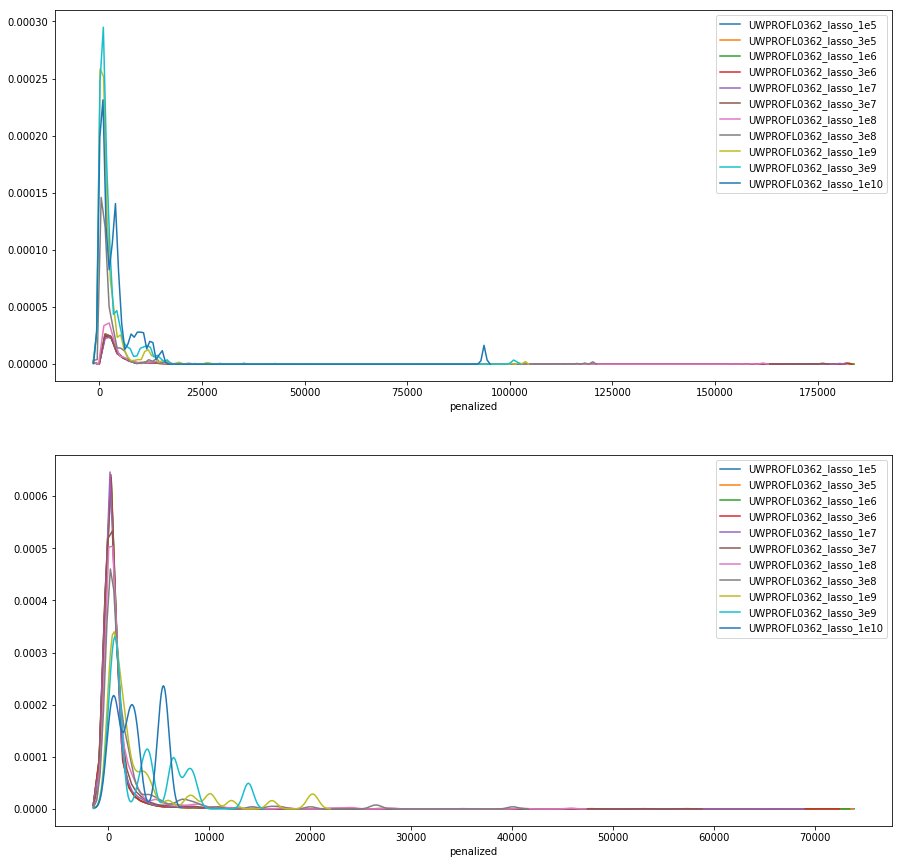

In [4]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))

for exp in experiment_iter("lasso", sample=["UWPROFL0362"]):
    lasso_peptides, lasso_decoys = get_experiment(exp)
    sns.distplot(get_max_values(lasso_peptides), ax=axs[0], 
                 hist=None, kde_kws={"bw": 500}, label=exp)
    sns.distplot(get_max_values(lasso_decoys), ax=axs[1], 
                 hist=None, kde_kws={"bw": 500}, label=exp)

plt.legend()
plt.show()

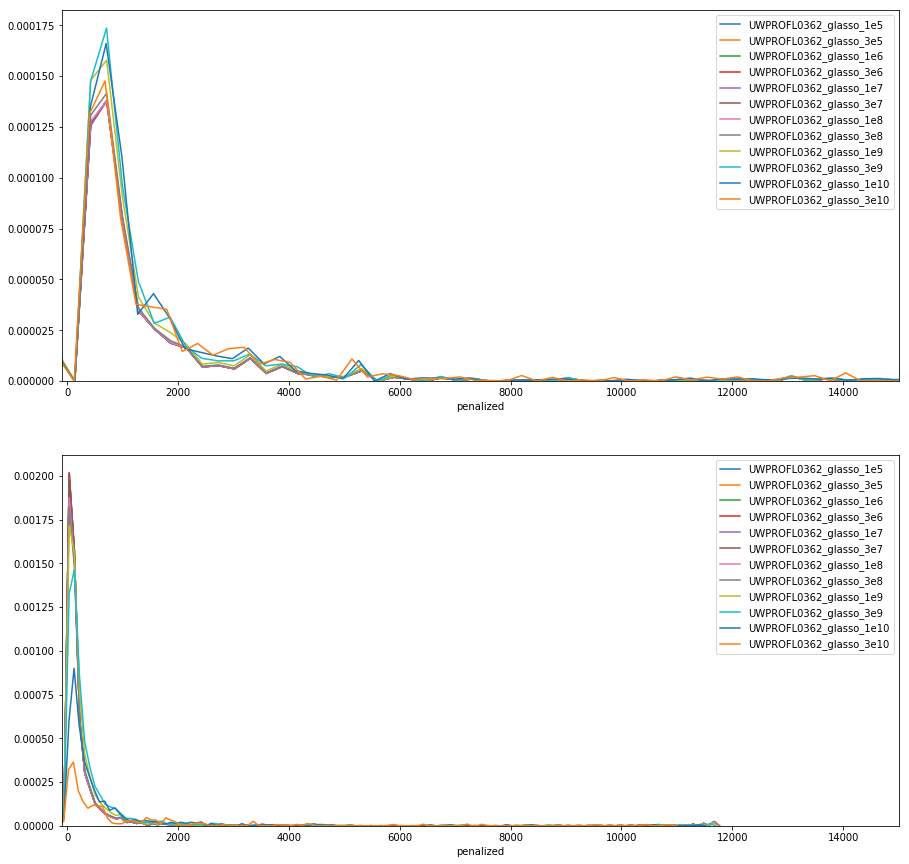

In [5]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))

for exp in experiment_iter("glasso", sample=["UWPROFL0362"]):
    if "1e11" in exp:
        break
    glasso_peptides, glasso_decoys = get_experiment(exp)
    sns.distplot(get_max_values(glasso_peptides), ax=axs[0], 
                 hist=None, kde_kws={"bw": 50}, label=exp)
    sns.distplot(get_max_values(glasso_decoys), ax=axs[1], 
                 hist=None, kde_kws={"bw": 50}, label=exp)

[a.set_xlim(-100, 15000) for a in axs]

plt.legend()
plt.show()

### Counting the number of peptide occurences 

In [6]:
def count_occurences(data):
    return data["peptide"].value_counts()

/net/gs/vol1/home/valenta4/.conda/envs/msms/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


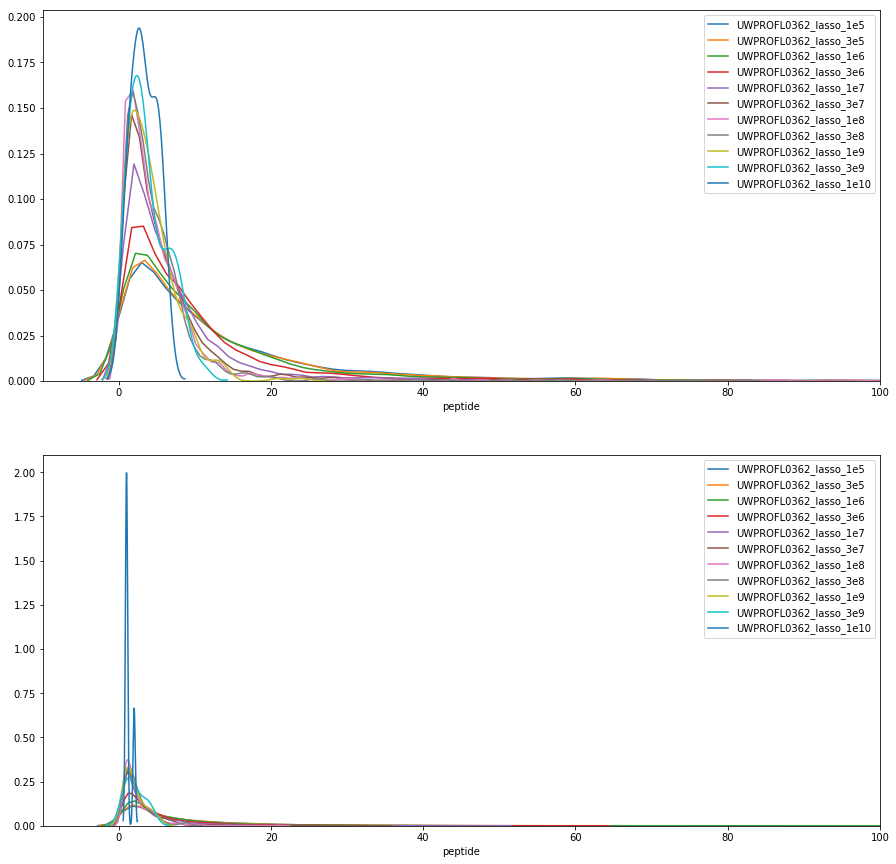

In [7]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))
for exp in experiment_iter("lasso", sample=["UWPROFL0362"]):
    lasso_peptides, lasso_decoys = get_experiment(exp)
    if lasso_peptides.shape[0] == 0 or lasso_decoys.shape[0] == 0:
        break
    lasso_peptides, lasso_decoys = value_filter(lasso_peptides, .5), value_filter(lasso_decoys, .5)
       
    sns.distplot(count_occurences(lasso_peptides), ax=axs[0], 
                 hist=False, label=exp)
    sns.distplot(count_occurences(lasso_decoys), ax=axs[1], 
                 hist=False, label=exp)

axs[0].set_xlim(-10, 100)
axs[1].set_xlim(-10, 100)

plt.legend()
plt.show()

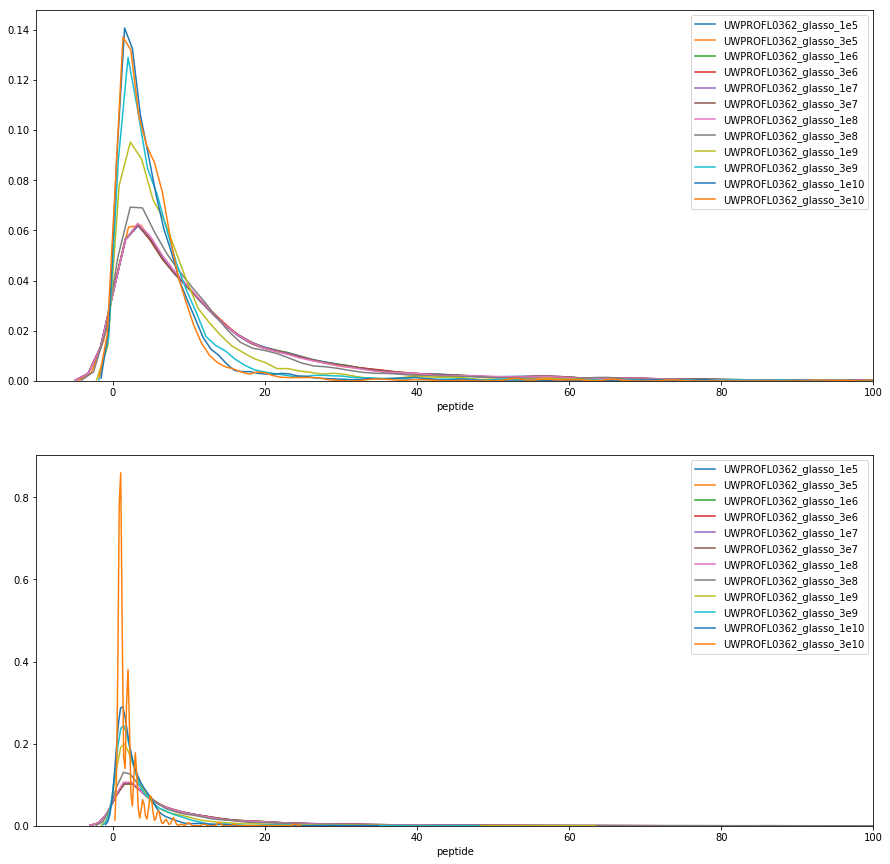

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))
for exp in experiment_iter("glasso", sample=["UWPROFL0362"]):
    if "1e11" in exp:
        break
    glasso_peptides, glasso_decoys = get_experiment(exp)
    glasso_peptides, glasso_decoys = value_filter(glasso_peptides, .5), value_filter(glasso_decoys, .5)
       
    sns.distplot(count_occurences(glasso_peptides), ax=axs[0], 
                 hist=False, label=exp)
    sns.distplot(count_occurences(glasso_decoys), ax=axs[1], 
                 hist=False, label=exp)

axs[0].set_xlim(-10, 100)
axs[1].set_xlim(-10, 100)

plt.legend()
plt.show()

### Counting number of matching peaks

In [9]:
def matching_peaks_wa(data):
    data = data.copy()
    data["matching"] *= data["penalized"]
    sums = data.groupby("peptide")["matching"].sum()
    return sums / data.groupby("peptide")["penalized"].sum()

/net/gs/vol1/home/valenta4/.conda/envs/msms/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/net/gs/vol1/home/valenta4/.conda/envs/msms/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/net/gs/vol1/home/valenta4/.conda/envs/msms/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


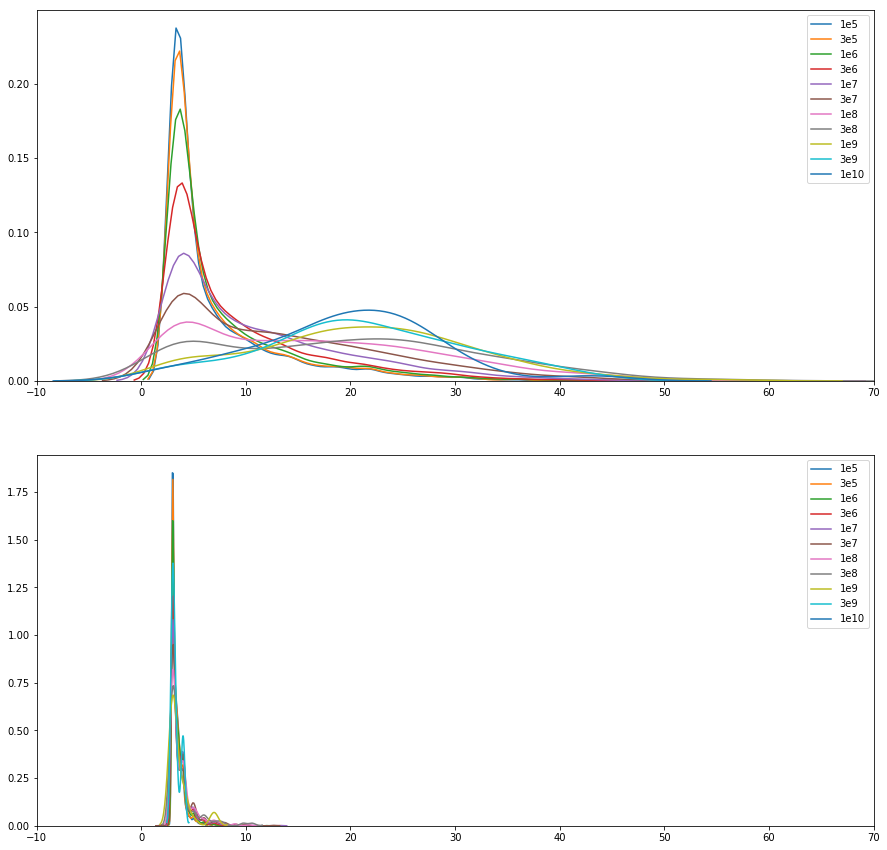

In [10]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))
for exp in experiment_iter("lasso", sample=["UWPROFL0362"]):
    lasso_peptides, lasso_decoys = get_experiment(exp)
    if lasso_peptides.shape[0] == 0 or lasso_decoys.shape[0] == 0:
        break
    lasso_peptides, lasso_decoys = value_filter(lasso_peptides, .5), value_filter(lasso_decoys, .5)
       
    sns.distplot(matching_peaks_wa(lasso_peptides), ax=axs[0], 
                 hist=False, label=exp.split("_")[-1])
    sns.distplot(matching_peaks_wa(lasso_decoys), ax=axs[1], 
                 hist=False, label=exp.split("_")[-1])

axs[0].set_xlim(-10, 70)
axs[1].set_xlim(-10, 70)

plt.legend()
plt.show()

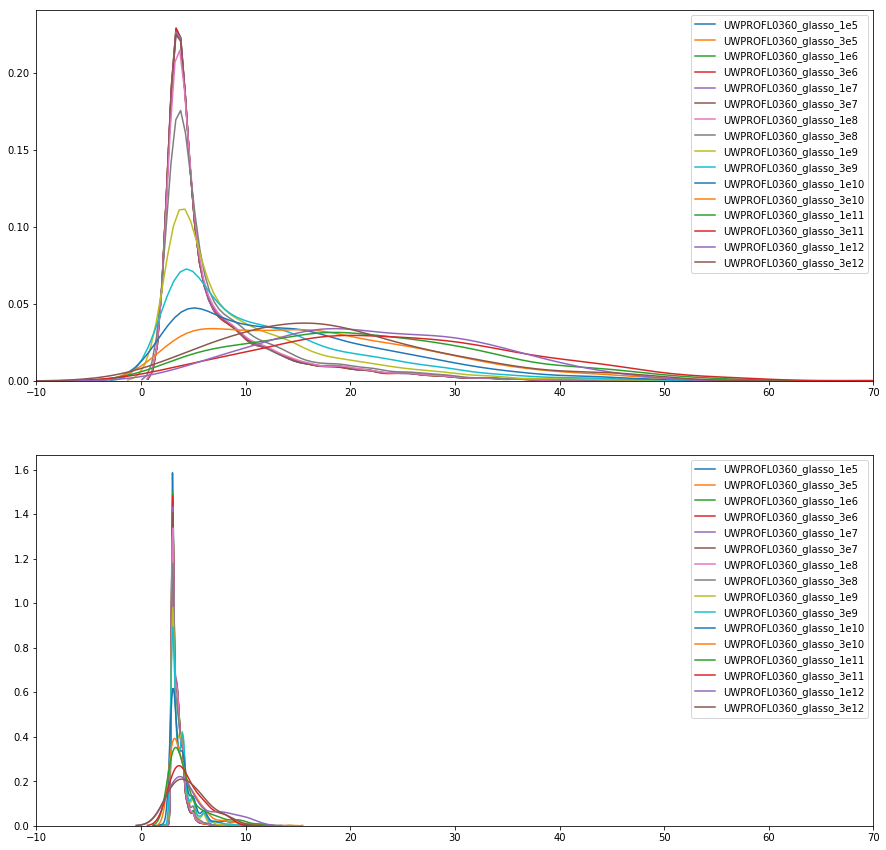

In [11]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15))
for exp in experiment_iter("glasso", sample=["UWPROFL0360"]):
    if "1e13" in exp:
        break
    glasso_peptides, glasso_decoys = get_experiment(exp)
    glasso_peptides, glasso_decoys = value_filter(glasso_peptides, .5), value_filter(glasso_decoys, .5)
       
    sns.distplot(matching_peaks_wa(glasso_peptides), ax=axs[0], 
                 hist=False, label=exp)
    sns.distplot(matching_peaks_wa(glasso_decoys), ax=axs[1], 
                 hist=False, label=exp)

axs[0].set_xlim(-10, 70)
axs[1].set_xlim(-10, 70)

plt.legend()
plt.show()

### Using a threshold to control FDR

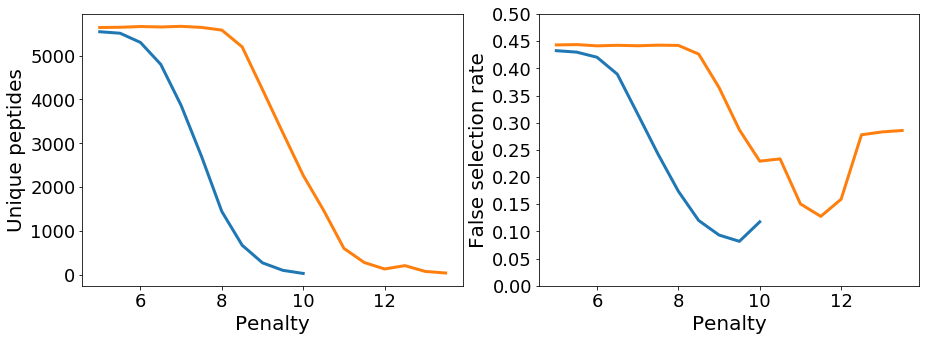

In [12]:
lasso_counts, lasso_fsr = [], []
for exp in experiment_iter("lasso", sample=["UWPROFL0362"]):
    lasso_peptides, lasso_decoys = get_experiment(exp)
    if lasso_peptides.shape[0] > 0:
        lasso_peptides, lasso_decoys = value_filter(lasso_peptides, 0.5), value_filter(lasso_decoys, 0.5)
        pcount = lasso_peptides.peptide.unique().size
        dcount = lasso_decoys.peptide.unique().size
        lasso_counts.append(pcount)
        lasso_fsr.append(dcount/(dcount + pcount))
    
glasso_counts, glasso_fsr = [], []
for exp in experiment_iter("glasso", sample=["UWPROFL0362"]):
    glasso_peptides, glasso_decoys = get_experiment(exp)
    if glasso_peptides.shape[0] > 0:
        glasso_peptides, glasso_decoys = value_filter(glasso_peptides, 0.5), value_filter(glasso_decoys, 0.5)
        pcount = glasso_peptides.peptide.unique().size
        dcount = glasso_decoys.peptide.unique().size
        glasso_counts.append(pcount)
        glasso_fsr.append(dcount/(dcount + pcount))

fig, axs = plt.subplots(ncols=2, nrows = 1, figsize=(15, 5))

axs[0].plot(np.arange(len(lasso_counts))/2 + 5, lasso_counts, lw = 3)
axs[0].plot(np.arange(len(glasso_counts))/2 + 5, glasso_counts, lw = 3)
axs[0].set_xlabel("Penalty", size = 20)
axs[0].set_ylabel("Unique peptides", size = 20)
axs[0].tick_params(labelsize=18)

axs[1].plot(np.arange(len(lasso_counts))/2 + 5, lasso_fsr, lw = 3)
axs[1].plot(np.arange(len(glasso_counts))/2 + 5, glasso_fsr, lw = 3)
axs[1].set_yticks(np.linspace(0.0, .5, 11))
axs[1].set_xlabel("Penalty", size = 20)
axs[1].set_ylabel("False selection rate", size = 20)
axs[1].tick_params(labelsize=18)
plt.show()

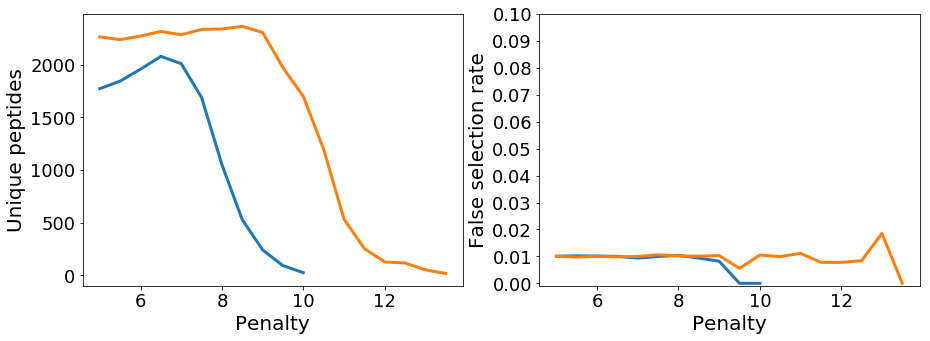

In [13]:
def fsr_cutoff(peptides, decoys, cutoff=0.01):
    pep_counts = matching_peaks_wa(peptides)
    decoy_counts = matching_peaks_wa(decoys)
    
    def optim(thresh):
        true_hits = np.sum(pep_counts >= thresh)
        false_hits = np.sum(decoy_counts >= thresh)
        fdr = false_hits/(true_hits + false_hits)
        return (cutoff - fdr)**2
    
    top_thresholds = np.random.uniform(0, 10, size = 3)
    for i in np.arange(-3, 2)[::-1]:
        sd = np.power(10., i)
        suggestions = sd * np.random.randn(10, 3) + top_thresholds
        scores = np.array([optim(t) for t in suggestions.flatten()])
        best_args = np.argsort(scores)[:3]
        top_thresholds = suggestions.flatten()[best_args]
    
    best_thresh = np.min(top_thresholds)
    return pep_counts[pep_counts >= best_thresh], decoy_counts[decoy_counts >= best_thresh]

lasso_counts, lasso_fsr = [], []
for exp in experiment_iter("lasso", sample=["UWPROFL0362"]):
    lasso_peptides, lasso_decoys = get_experiment(exp)
    if lasso_peptides.shape[0] > 0:
        lasso_peptides, lasso_decoys = value_filter(lasso_peptides, 0.5), value_filter(lasso_decoys, 0.5)
        selected_peptides, selected_decoys = fsr_cutoff(lasso_peptides, lasso_decoys)
        pcount = selected_peptides.size
        dcount = selected_decoys.size
        lasso_counts.append(pcount)
        lasso_fsr.append(dcount/(dcount + pcount))
    
glasso_counts, glasso_fsr = [], []
for exp in experiment_iter("glasso", sample=["UWPROFL0362"]):
    glasso_peptides, glasso_decoys = get_experiment(exp)
    if glasso_peptides.shape[0] > 0:
        glasso_peptides, glasso_decoys = value_filter(glasso_peptides, 0.5), value_filter(glasso_decoys, 0.5)
        selected_peptides, selected_decoys = fsr_cutoff(glasso_peptides, glasso_decoys)
        pcount = selected_peptides.size
        dcount = selected_decoys.size
        glasso_counts.append(pcount)
        glasso_fsr.append(dcount/(dcount + pcount))

fig, axs = plt.subplots(ncols=2, nrows = 1, figsize=(15, 5))

axs[0].plot(np.arange(len(lasso_counts))/2 + 5, lasso_counts, lw = 3)
axs[0].plot(np.arange(len(glasso_counts))/2 + 5, glasso_counts, lw = 3)
axs[0].set_xlabel("Penalty", size = 20)
axs[0].set_ylabel("Unique peptides", size = 20)
axs[0].tick_params(labelsize=18)

axs[1].plot(np.arange(len(lasso_counts))/2 + 5, lasso_fsr, lw = 3)
axs[1].plot(np.arange(len(glasso_counts))/2 + 5, glasso_fsr, lw = 3)
axs[1].set_yticks(np.linspace(0.0, .1, 11))
axs[1].set_xlabel("Penalty", size = 20)
axs[1].set_ylabel("False selection rate", size = 20)
axs[1].tick_params(labelsize=18)
plt.savefig("selection_vs_penalty.png")
plt.show()

In [14]:
def count_silac_pairs(arr):
    mod_arr = [re.sub('K[^a-zA-Z\/]+', "K", p) for p in arr]
    return arr.shape[0] - np.unique(mod_arr).shape[0]

In [15]:
lasso_pairs = []
for exp in experiment_iter("lasso", sample=["UWPROFL0362"]):
    lasso_peptides, lasso_decoys = get_experiment(exp)
    uniques = lasso_peptides[1].unique()
    if uniques.shape[0] > 0:
        lasso_pairs.append(count_silac_pairs(uniques)/uniques.shape[0])
    
glasso_pairs = []
for exp in experiment_iter("glasso", sample=["UWPROFL0362"]):
    glasso_peptides, glasso_decoys = get_experiment(exp)
    uniques = glasso_peptides[1].unique()
    if uniques.shape[0] > 0:
        glasso_pairs.append(count_silac_pairs(uniques)/uniques.shape[0])

plt.figure(figsize = (10, 5))
plt.plot(np.arange(len(lasso_pairs)) + 5, lasso_pairs, lw = 3)
plt.plot(np.arange(len(glasso_pairs)) + 5, glasso_pairs, lw = 3)
plt.xlabel("Penalty", size = 20)
plt.ylabel("Proportion with pair", size = 20)
plt.tick_params(labelsize=18)
plt.savefig("pairs_vs_penalty.png")
plt.xlim(5, 10)
plt.ylim(.35, .5)
plt.show()

KeyError: 1